In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.filters as flt
from skimage.metrics import structural_similarity as SSIM
%matplotlib inline
# since we can't use imports
import numpy as np
import scipy.ndimage.filters as flt
import warnings
import cv2
from glob import glob 

import pylab as pl
from time import sleep
import tensorflow as tf
from tqdm import tqdm
from collections import Counter
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib as mpl


import sys
sys.path.append('../../scripts')
import open_frame
from pm_algorithm import anisodiff
from data_augmentation import get_generators
from architectures import get_model


CROP = 256
image_size = (CROP,CROP)
typ = "gaussian"
open_frame = getattr(open_frame,typ)


import logging
tf.get_logger().setLevel(logging.ERROR)

## Data augmentation

In [3]:
gen_batch_train,gen_batch_val = get_generators(typ,var1_d=1,var1_u=7,CROP1=CROP,BATCH_SIZE=50)

In [4]:
xs, ys = next(gen_batch_val.as_numpy_iterator())

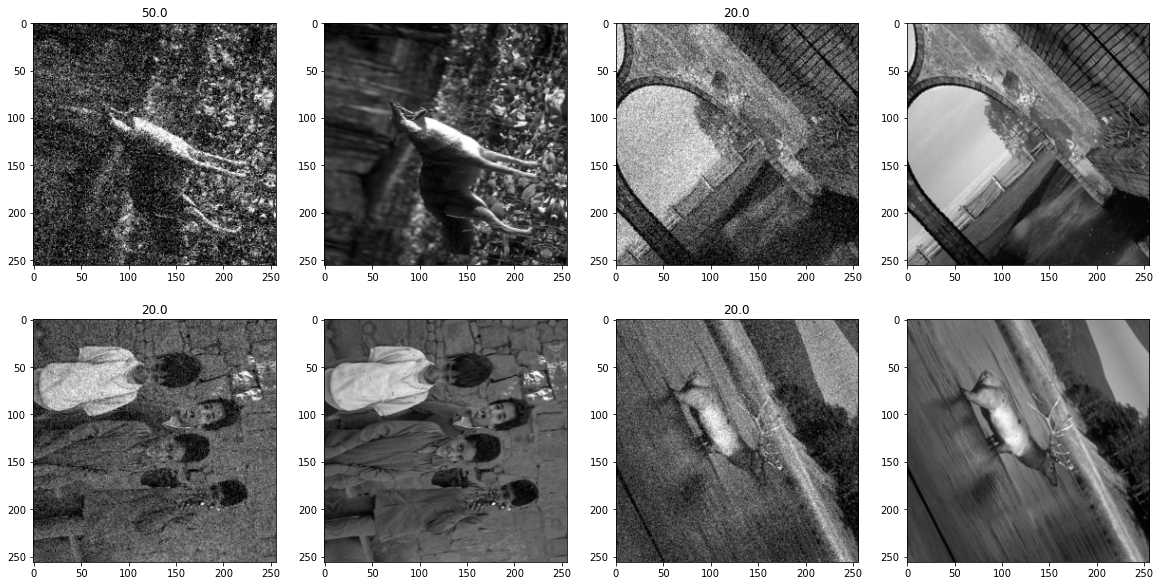

In [5]:
nrows,ncols = 2,4
fig,axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(20,10))

for i in range(nrows):
    for j in range(ncols//2):
        _ = np.random.choice(len(xs['input']))
        axs[i,2*j].imshow(np.squeeze(xs['input'][_]),cmap='gray')
        axs[i,2*j+1].imshow(np.squeeze(ys[_]),cmap='gray')
        axs[i,2*j].set_title(str(np.mean(xs['input_emb'][_])))
        
plt.show()

# Neural networks

In [8]:
strategy = tf.distribute.MirroredStrategy()
#strategy = tf.distribute.OneDeviceStrategy('/device:GPU:0')

## Training

In [2]:
def loss(y_true,y_pred):
    error = tf.maximum(0.,1/tf.image.psnr(y_true,y_pred,1))
    error += (1-tf.image.ssim(y_true,y_pred,1))
    error += tf.maximum(0.,tf.math.log(tf.keras.losses.MeanSquaredError()(y_true,y_pred)))
    return error

In [11]:
gen_batch_train,gen_batch_val = get_generators(typ,var1_d=20,var1_u=60,CROP1=CROP,BATCH_SIZE=32)

order = 1
for num_classes in [50]:
    print('num_classes: ',num_classes)
    model = get_model("decreasing_linear",it_lim=3,image_size=image_size,num_classes = num_classes,order=order)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
            loss=loss,)
    #model.load_weights(f"./checkpoints/splines_{typ}_{num_classes}")
    
    callbacks = [tf.keras.callbacks.ModelCheckpoint(
    filepath= f"./checkpoints/declinear_{typ}_{num_classes}",
    save_weights_only=True,
    verbose = True,
    save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, verbose=1)
    ]
    
    history = model.fit(
        gen_batch_train,
        epochs=30,
        steps_per_epoch=50,
        validation_data=gen_batch_val,
        validation_steps=10,
        shuffle=False,
        use_multiprocessing=True,
        callbacks=callbacks,
        workers=1
    )
    
    np.save(f'./history/declinear_{typ}_{num_classes}.npy',np.array([history.history['loss'],history.history['val_loss']]))
    

num_classes:  50
Epoch 1/30
50/50 [==============================] - ETA: 0s - loss: 3.1934
Epoch 00001: val_loss improved from inf to 0.47113, saving model to ./checkpoints/declinear_gaussian_50
50/50 [==============================] - 54s 1s/step - loss: 3.1934 - val_loss: 0.4711 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - ETA: 0s - loss: 0.4292
Epoch 00002: val_loss did not improve from 0.47113
50/50 [==============================] - 50s 1s/step - loss: 0.4292 - val_loss: 0.4739 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - ETA: 0s - loss: 0.3330
Epoch 00003: val_loss improved from 0.47113 to 0.42886, saving model to ./checkpoints/declinear_gaussian_50
50/50 [==============================] - 50s 1s/step - loss: 0.3330 - val_loss: 0.4289 - lr: 0.0010
Epoch 4/30
50/50 [==============================] - ETA: 0s - loss: 0.3147
Epoch 00004: val_loss improved from 0.42886 to 0.40913, saving model to ./checkpoints/declinear_gaussian_50
50/50 [=====

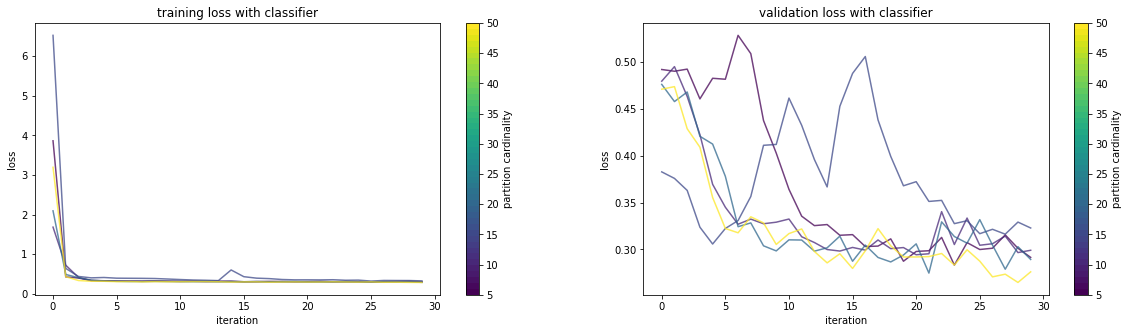

In [12]:
trained = glob(f'./history/declinear_*')
w = [int(i.split('_')[-1].split('.')[0]) for i in trained]
n = len(trained)+1
viridis = cm.get_cmap('viridis', 256)
colors = viridis(np.linspace(0, 1, np.amax(w)-np.amin(w)+1))
newcmp = ListedColormap(colors)
norm = mpl.colors.Normalize(vmin=np.amin(w), vmax=np.amax(w))

fig,axs = plt.subplots(ncols=2,figsize=(20,5))

for j,i in enumerate(trained):
    
    v = np.load(i)
    axs[0].plot(v[0],alpha=0.75,color = colors[w[j]-np.amin(w)])
    axs[1].plot(v[1],alpha=0.75,color = colors[w[j]-np.amin(w)])
    
axs[0].set_title("training loss with classifier")
axs[1].set_title("validation loss with classifier")

axs[0].set_xlabel('iteration')
axs[0].set_ylabel('loss')

axs[1].set_xlabel('iteration')
axs[1].set_ylabel('loss')
    
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=newcmp),ax=axs[0],label='partition cardinality')
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=newcmp),ax=axs[1],label='partition cardinality')
    
plt.show()



# Results

# Results with first function

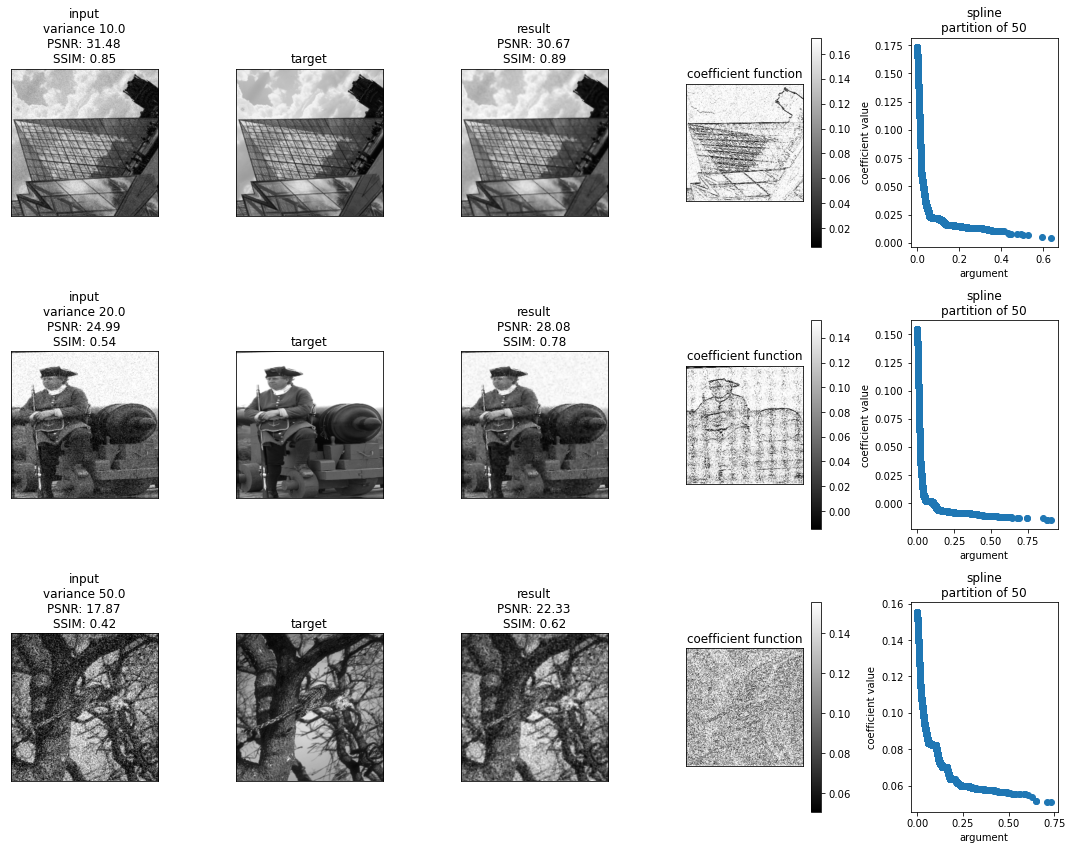

In [17]:
order = 1
num_classes = 50
model = get_model("decreasing_linear",it_lim=3,image_size=image_size,num_classes = num_classes,order=order)
model.load_weights(f"./checkpoints/declinear_{typ}_{num_classes}")

w = [10,20,50]
fig,axs = plt.subplots(ncols = 5,nrows = int(np.ceil(len(w))),figsize=(15,4*len(w)))
for i,m in enumerate(w):

    
    gen_batch_train,gen_batch_val = get_generators(typ,var1_d=0,var1_u=w[i],CROP1=CROP,BATCH_SIZE=50)
    ims = next(gen_batch_val.as_numpy_iterator())
    p = np.clip(model(ims[0]),0,1)
    _ = np.where(ims[0]['input_emb'].flatten()==w[i])[0][0]

    psnr_0 = tf.image.psnr(ims[0]['input'][_],ims[1][_],1).numpy()
    ssim_0 = tf.image.ssim(ims[0]['input'][_],ims[1][_],1).numpy()
    clean = p[_]
    psnr = tf.image.psnr(ims[1][_],clean,1).numpy()
    ssim = tf.image.ssim(ims[1][_],clean,1).numpy()
    clean = np.squeeze(clean)
    inputs = tf.keras.Input(shape=image_size + (1,))
    get_lambdas = tf.keras.models.Model(model.input,model.get_layer('coeff_spline').output)
    spline = np.squeeze(get_lambdas(ims[0])[_])
    visualization = tf.keras.models.Model(model.input,model.get_layer('gS_0').output)
    vis = np.squeeze(visualization(ims[0])[_])
    axx_layers = tf.keras.models.Model(model.input,model.get_layer('dx_0').output)
    axx = np.squeeze(axx_layers(ims[0])[_])


    psnr_0,ssim_0 = int(100*psnr_0)/100,int(100*ssim_0)/100
    psnr,ssim = int(100*psnr)/100,int(100*ssim)/100
    
    
    axs[i,0].imshow(ims[0]['input'][_],cmap='gray')
    axs[i,0].set_title(f'input\nvariance {int(100*m)/100}\nPSNR: {psnr_0}\nSSIM: {ssim_0}')
    axs[i,0].set_xticks([])
    axs[i,0].set_xticklabels([])
    axs[i,0].set_yticks([])
    axs[i,0].set_yticklabels([])
    axs[i,1].imshow(ims[1][_],cmap='gray')
    axs[i,1].set_title('target')
    axs[i,1].set_xticks([])
    axs[i,1].set_xticklabels([])
    axs[i,1].set_yticks([])
    axs[i,1].set_yticklabels([])
    axs[i,2].imshow(clean,cmap='gray')
    axs[i,2].set_title(f'result\nPSNR: {psnr}\nSSIM: {ssim}')
    axs[i,2].set_xticks([])
    axs[i,2].set_xticklabels([])
    axs[i,2].set_yticks([])
    axs[i,2].set_yticklabels([])
    im = axs[i,3].imshow(vis,cmap='gray')
    axs[i,3].set_title('coefficient function')
    plt.colorbar(im,ax=axs[i,3])
    axs[i,3].set_xticks([])
    axs[i,3].set_xticklabels([])
    axs[i,3].set_yticks([])
    axs[i,3].set_yticklabels([])
    
    x = np.ndarray.flatten(axx)
    s = np.ndarray.flatten(vis)
    
    
    axs[i,4].scatter(x,s)
    axs[i,4].set_xlabel("argument")
    axs[i,4].set_ylabel("coefficient value")
    axs[i,4].set_title(f"spline\npartition of {num_classes}")
    
plt.tight_layout()
plt.show()

# Comparing against Perona Malik

2023-02-07 18:42:11.512477: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-07 18:42:11.512704: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-07 18:42:11.539126: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-07 18:42:11.539361: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-07 18:42:11.539538: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

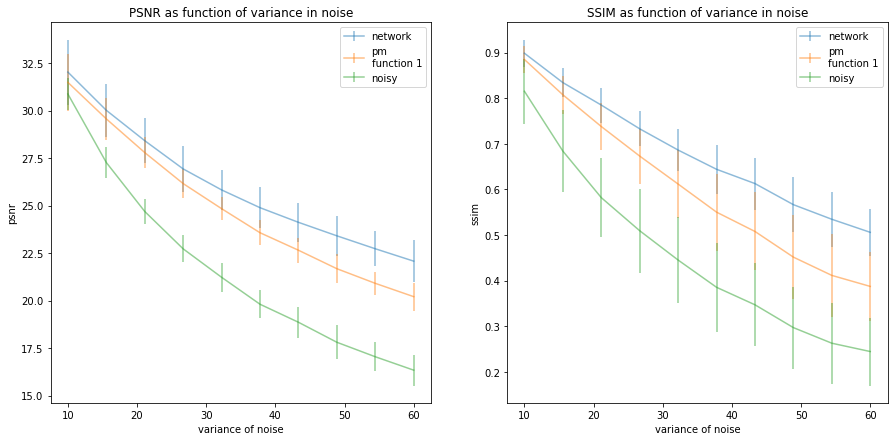

In [2]:
num_classes = 50
model = get_model("decreasing_linear",it_lim=3,image_size=image_size,num_classes = num_classes)
model.load_weights(f"./checkpoints/declinear_{typ}_{num_classes}")

w = np.linspace(10,60,10)
psnr_nn_1,psnr_nn_s_1 = [],[]
ssim_nn_1,ssim_nn_s_1 = [],[]

psnr_pm_1,psnr_pm_s_1 = [],[]
ssim_pm_1,ssim_pm_s_1 = [],[]

psnr_or_1,psnr_or_s_1 = [],[]
ssim_or_1,ssim_or_s_1 = [],[]


for i,m in enumerate(w):
    gen_batch_train,gen_batch_val = get_generators(typ,0,w[i],CROP1=CROP,BATCH_SIZE=10)
    
    psnr_nn_1.append([])
    psnr_nn_s_1.append([])
    ssim_nn_1.append([])
    ssim_nn_s_1.append([])
    psnr_pm_1.append([])
    psnr_pm_s_1.append([])
    ssim_pm_1.append([])
    ssim_pm_s_1.append([])
    psnr_or_1.append([])
    psnr_or_s_1.append([])
    ssim_or_1.append([])
    ssim_or_s_1.append([])
    
    for it in range(10):
        ims = next(gen_batch_val.as_numpy_iterator())

        res = model(ims[0])
        psnr = tf.image.psnr(res,ims[1],1).numpy()
        ssim = tf.image.ssim(res,ims[1],1).numpy()
        psnr_nn_1[-1].append(np.copy(psnr))
        psnr_nn_s_1[-1].append(np.copy(psnr))
        ssim_nn_1[-1].append(np.copy(ssim))
        ssim_nn_s_1[-1].append(np.copy(ssim))

        pm = np.array([anisodiff(im,niter = 3,lambd=50) for im in ims[0]['input']])
        pm = np.asarray(pm,dtype='float32')
        psnr = [tf.image.psnr(pm[j],ims[1][j],1).numpy() for j in range(len(res))]
        ssim = [tf.image.ssim(pm[j],ims[1][j],1).numpy() for j in range(len(res))]
        psnr_pm_1[-1].append(np.copy(psnr))
        psnr_pm_s_1[-1].append(np.copy(psnr))
        ssim_pm_1[-1].append(np.copy(ssim))
        ssim_pm_s_1[-1].append(np.copy(ssim))

        psnr = tf.image.psnr(ims[0]['input'],ims[1],1).numpy()
        ssim = tf.image.ssim(ims[0]['input'],ims[1],1).numpy()
        psnr_or_1[-1].append(np.copy(psnr))
        psnr_or_s_1[-1].append(np.copy(psnr))
        ssim_or_1[-1].append(np.copy(ssim))
        ssim_or_s_1[-1].append(np.copy(ssim))
        
    psnr_nn_1[-1] = np.concatenate(psnr_nn_1[-1])
    psnr_nn_s_1[-1] = np.concatenate(psnr_nn_s_1[-1])
    ssim_nn_1[-1] = np.concatenate(ssim_nn_1[-1])
    ssim_nn_s_1[-1] = np.concatenate(ssim_nn_s_1[-1])
    
    psnr_pm_1[-1] = np.concatenate(psnr_pm_1[-1])
    psnr_pm_s_1[-1] = np.concatenate(psnr_pm_s_1[-1])
    ssim_pm_1[-1] = np.concatenate(ssim_pm_1[-1])
    ssim_pm_s_1[-1] = np.concatenate(ssim_pm_s_1[-1])
    
    psnr_or_1[-1] = np.concatenate(psnr_or_1[-1])
    psnr_or_s_1[-1] = np.concatenate(psnr_or_s_1[-1])
    ssim_or_1[-1] = np.concatenate(ssim_or_1[-1])
    ssim_or_s_1[-1] = np.concatenate(ssim_or_s_1[-1])
    
    


psnr_nn_1 = np.mean(psnr_nn_1,axis=-1)
psnr_nn_s_1 = np.std(psnr_nn_s_1,axis=-1)
ssim_nn_1 = np.mean(ssim_nn_1,axis=-1)
ssim_nn_s_1 = np.std(ssim_nn_s_1,axis=-1)
psnr_pm_1 = np.mean(psnr_pm_1,axis=-1)
psnr_pm_s_1 = np.std(psnr_pm_s_1,axis=-1)
ssim_pm_1 = np.mean(ssim_pm_1,axis=-1)
ssim_pm_s_1 = np.std(ssim_pm_s_1,axis=-1)
psnr_or_1 = np.mean(psnr_or_1,axis=-1)
psnr_or_s_1 = np.std(psnr_or_s_1,axis=-1)
ssim_or_1 = np.mean(ssim_or_1,axis=-1)
ssim_or_s_1 = np.std(ssim_or_s_1,axis=-1)

plt.figure(figsize=(15,7))
plt.subplot(121)
plt.errorbar(w,psnr_nn_1,psnr_nn_s_1,label='network',alpha=0.5)
plt.errorbar(w,psnr_pm_1,psnr_pm_s_1,label='pm\nfunction 1',alpha=0.5)
plt.errorbar(w,psnr_or_1,psnr_or_s_1,label='noisy',alpha=0.5)


plt.xlabel('variance of noise')
plt.ylabel('psnr')
plt.title('PSNR as function of variance in noise')
plt.legend()

plt.subplot(122)
plt.errorbar(w,ssim_nn_1,ssim_nn_s_1,label='network',alpha=0.5)
plt.errorbar(w,ssim_pm_1,ssim_pm_s_1,label='pm\nfunction 1',alpha=0.5)
plt.errorbar(w,ssim_or_1,ssim_or_s_1,label='noisy',alpha=0.5)


plt.xlabel('variance of noise')
plt.ylabel('ssim')
plt.title('SSIM as function of variance in noise')
plt.legend()
plt.show()

/tmp/ipykernel_837521/301148677.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ims = np.array(next(gen_batch_val.as_numpy_iterator()))


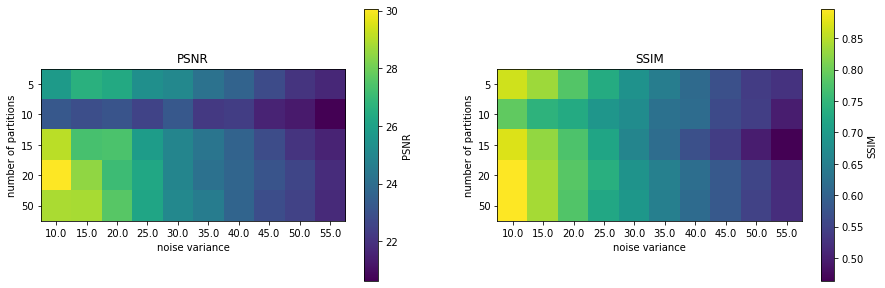

In [6]:
order = 1
w = np.linspace(10,55,10)
w = np.asarray(100*w,dtype='int')/100
ncl = np.sort([int(i.split('_')[-1].split('.')[0]) for i in glob(f"./checkpoints/declinear_{typ}_*.index")])


hist_psnr,hist_ssim = [],[]

for num_classes in ncl:

    psnr_nn_1,ssim_nn_1 = [],[]
    model = get_model("decreasing_linear",it_lim=3,image_size=image_size,num_classes = num_classes,order=order)
    for i,m in enumerate(w):
        
        model.load_weights(f"./checkpoints/declinear_{typ}_{num_classes}")
        gen_batch_train,gen_batch_val = get_generators(typ,0,w[i],CROP1=CROP,BATCH_SIZE=10)
        
        psnr_nn_1.append([])
        ssim_nn_1.append([])
        for it in range(10):
            ims = np.array(next(gen_batch_val.as_numpy_iterator()))

            res = model(ims[0])
            res = res/np.expand_dims(np.expand_dims(np.amax(res,axis=(1,2)),axis=-2),axis=-2)
            psnr = [tf.image.psnr(res[j],ims[1][j],1).numpy() for j in range(len(res))]
            ssim = [tf.image.ssim(res[j],ims[1][j],1).numpy() for j in range(len(res))]
            psnr_nn_1[-1].append(psnr)
            ssim_nn_1[-1].append(ssim)
            
        psnr_nn_1[-1] = np.mean(psnr_nn_1[-1])
        ssim_nn_1[-1] = np.mean(ssim_nn_1[-1])


    hist_psnr.append(np.copy(psnr_nn_1))
    hist_ssim.append(np.copy(ssim_nn_1))
    

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(hist_psnr)
plt.xlabel('noise variance')
plt.ylabel('number of partitions')
plt.title('PSNR')
plt.colorbar(label='PSNR')
plt.xticks(np.arange(len(w)),w)
plt.yticks(np.arange(len(ncl)),ncl)
plt.subplot(122)
plt.imshow(hist_ssim)
plt.xlabel('noise variance')
plt.ylabel('number of partitions')
plt.title('SSIM')
plt.colorbar(label='SSIM')
plt.xticks(np.arange(len(w)),w)
plt.yticks(np.arange(len(ncl)),ncl)
plt.show()

# Analizing functions for coefficients

In [47]:
order = 1
w = np.linspace(10,60,20)
ncl = np.sort([int(i.split('_')[-1].split('.')[0]) for i in glob(f"./checkpoints/declinear_{typ}_*.index")])
xR,R = [],[]

for num_classes in ncl:
    model = get_model("decreasing_linear",it_lim=3,image_size=image_size,num_classes = num_classes)
    model.load_weights(f"./checkpoints/declinear_{typ}_{num_classes}")
    get_lambdas = tf.keras.models.Model(model.input,model.get_layer('coeff_spline').output)
    
    R.append([])
    xR.append([])
    s = []
    for i,m in enumerate(w):


        gen_batch_train,gen_batch_val = get_generators(typ,var1_d=0,var1_u=w[i],CROP1=CROP,BATCH_SIZE=10)
        
        spline = []
        for it in range(10):
        
            ims = next(gen_batch_val.as_numpy_iterator())
            spl = np.squeeze(get_lambdas(ims[0]))
            for _ in range(len(spl)):
                
                x = np.linspace(0,1,1000)
                linear = np.concatenate([[spl[_][en][1] for j in range(len(x)//num_classes)] for en in range(len(spl[_]))])
                linear = np.concatenate((linear,linear[-1]*np.ones(len(x)-len(linear))))
                cte = np.concatenate([[spl[_][en][0] for j in range(len(x)//num_classes)] for en in range(len(spl[_]))])
                cte = np.concatenate((cte,cte[-1]*np.ones(len(x)-len(cte))))
                spline.append(cte + np.multiply(linear,np.mod(x,1/num_classes)))
    
    
        R[-1].append(np.copy(np.mean(spline,axis=0)))

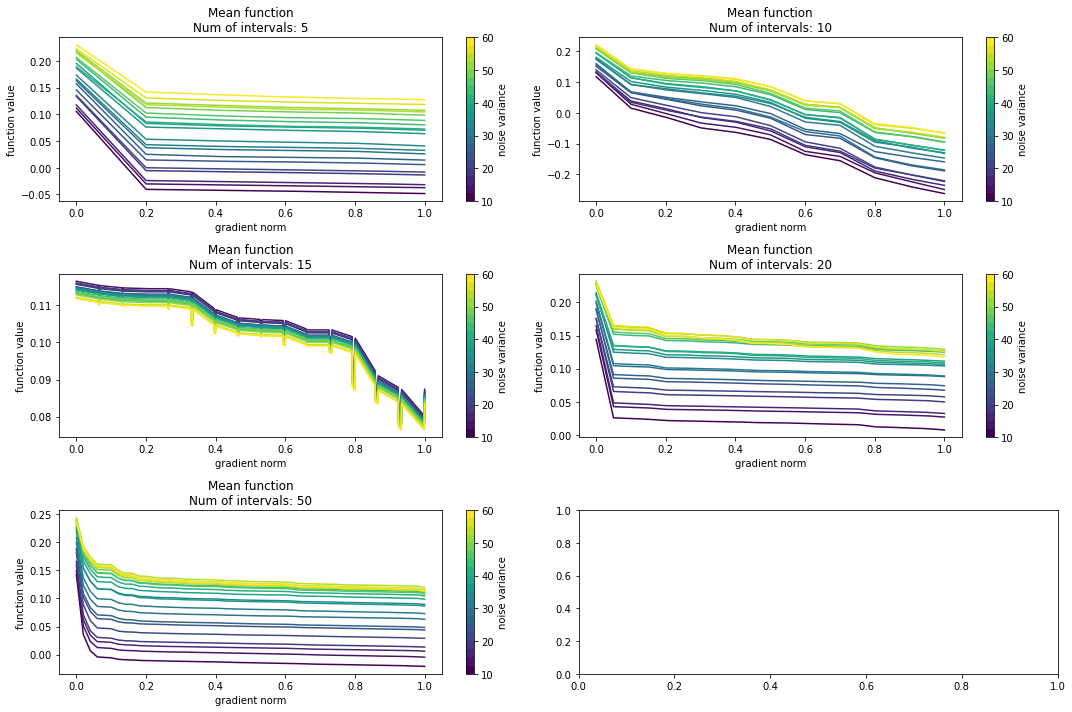

In [48]:
norm = mpl.colors.Normalize(vmin=np.amin(w), vmax=np.amax(w))

fig,axs = plt.subplots(ncols = 2,nrows = 3,figsize=(15,10))

for col in range(len(R)):
        
    if len(R[col]) == 0:
        continue

    viridis = cm.get_cmap('viridis', 256)
    colors = viridis(np.linspace(0, 1, len(R[col])))
    newcmp = ListedColormap(colors)

    for i in range(len(R[col])):

        #m,s = R[col][i].T

        #axs[col].errorbar(np.arange(len(m))/ncl[col],m,s,color=colors[i])
        axs[col//2,col%2].plot(np.linspace(0,1,1000),R[col][i],color=colors[i])

    axs[col//2,col%2].set_title(f"Mean function\nNum of intervals: {ncl[col]}")
    axs[col//2,col%2].set_xlabel("gradient norm")
    axs[col//2,col%2].set_ylabel("function value")
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=newcmp),ax=axs[col//2,col%2],label='noise variance')

plt.tight_layout()        
plt.show()

# Plot the model

In [3]:
model = get_model("decreasing_linear",it_lim=3,image_size=image_size,num_classes = 5)

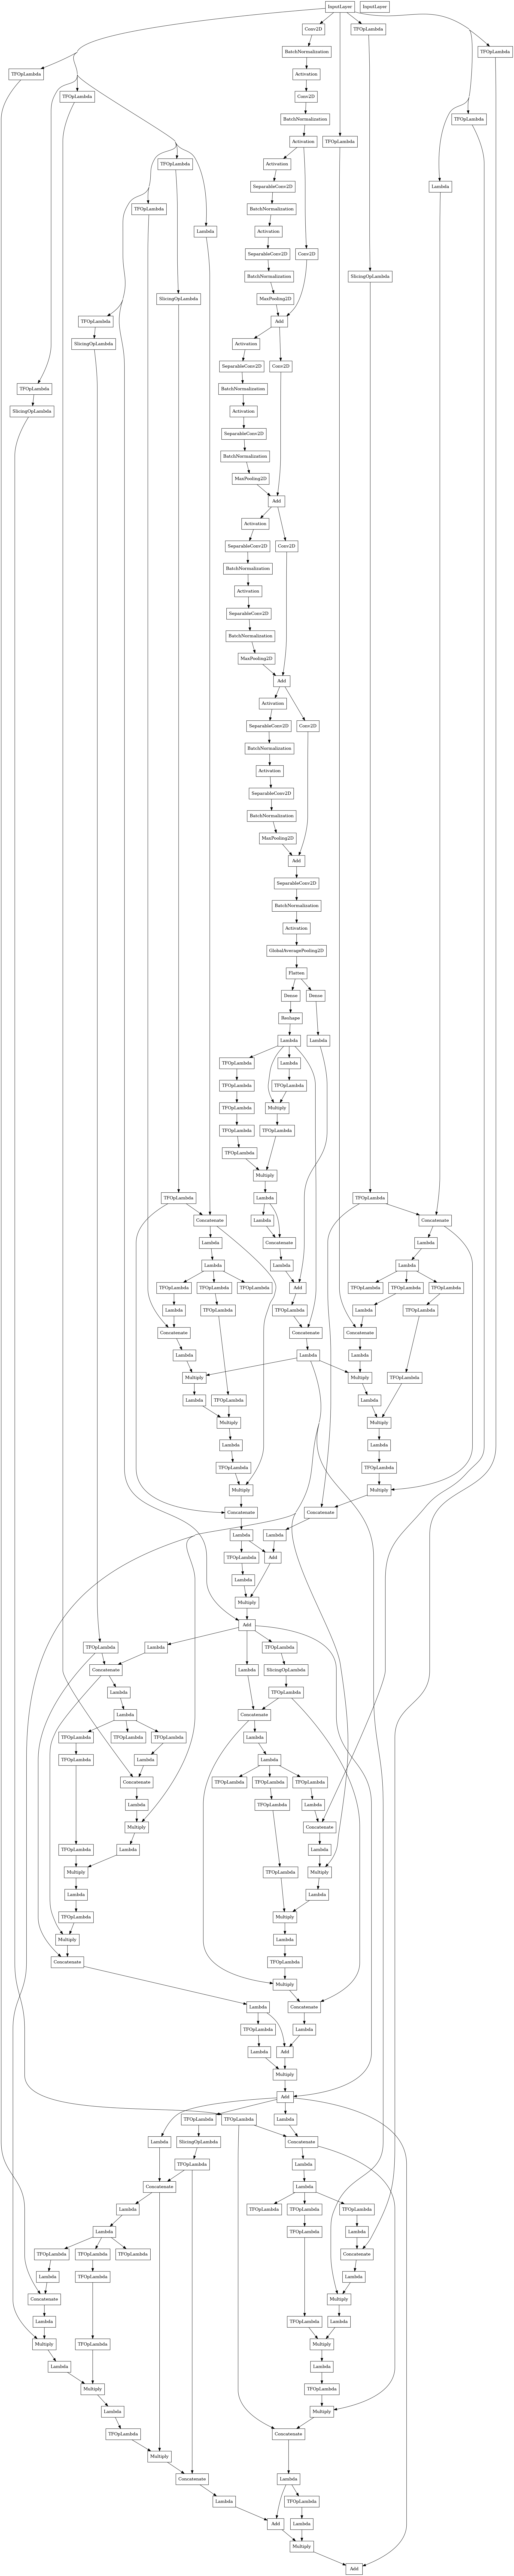

In [4]:
tf.keras.utils.plot_model(model,
    to_file="decresing_linear.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=False,)